In [1]:
import numpy as np
import os

from standard_tester import *

from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
# as chosen in Nguyen 2014
ks = [RBF(name='rbf0')]
ranks = [2]
# all_ixs is union of all xss, holdout, holdin are dictionaries of slices
xss, yss, test_xss, test_yss, fx2007, all_ixs, holdout, holdin = foreign_exchange_2007()
pred_xss = test_xss
cache_dir = '/tmp/'
inducing_points = np.arange(10, 201, 10)

In [3]:
file_cached_vars = ['runlmc_times', 'runlmc_smses', 'runlmc_nlpds']
if all(os.path.isfile(cache_dir + file) for file in file_cached_vars):
    runlmc_times, runlmc_smses, runlmc_nlpds = [
        list(np.loadtxt(cache_dir + i)) for i in file_cached_vars]
else:
    num_runs = 5
    runlmc_times, runlmc_smses, runlmc_nlpds = [], [], []
    for m in inducing_points[inducing_points]:
        time, smse, nlpd, _ = runlmc(
            num_runs, m,
            xss, yss, test_xss, test_yss,
            ks, ranks, {'max_it': 10000, 'verbosity':0})
        print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
        runlmc_times.append(time)
        runlmc_smses.append(smse)
        runlmc_nlpds.append(nlpd)
    for i in file_cached_vars:
        np.savetxt(cache_dir + i, eval(i))

In [4]:
cogp_file_cached_vars = ['cogp_times', 'cogp_smses', 'cogp_nlpds']
if all(os.path.isfile(cache_dir + file) for file in cogp_file_cached_vars):
    cogp_times, cogp_smses, cogp_nlpds = [
        list(np.loadtxt(cache_dir + i)) for i in cogp_file_cached_vars]
else:
    cogp_num_runs = 2
    cogp_times, cogp_smses, cogp_nlpds = [], [], []
    for m in inducing_points:
        time, smse, nlpd = cogp_fx2007(cogp_num_runs, m)
        print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
        cogp_times.append(time)
        cogp_smses.append(smse)
        cogp_nlpds.append(nlpd)
    for i in cogp_file_cached_vars:
        np.savetxt(cache_dir + i, eval(i))        

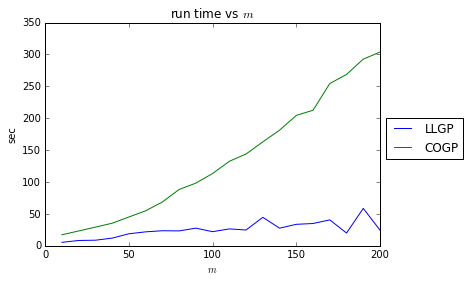

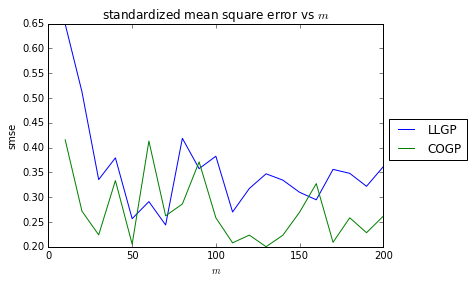

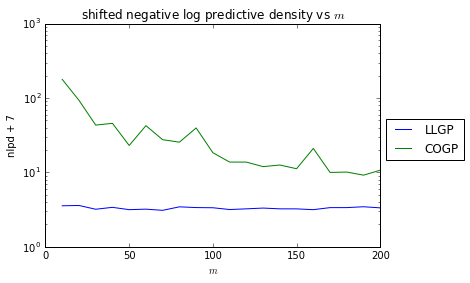

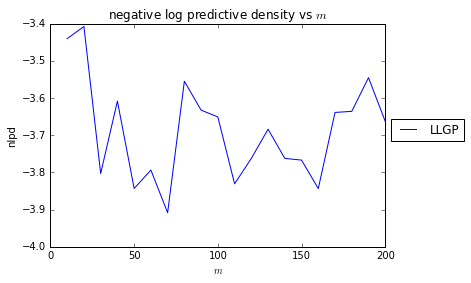

In [5]:
#also runlmc_nlpds, cogp_nlpds
plt.plot(inducing_points, runlmc_times, label='LLGP')
plt.plot(inducing_points, cogp_times, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'run time vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('sec')
plt.show()
plt.plot(inducing_points, runlmc_smses, label='LLGP')
plt.plot(inducing_points, cogp_smses, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'standardized mean square error vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('smse')
plt.show()
shift = min(min(runlmc_nlpds), min(cogp_nlpds))
assert shift < 0
shift = int(abs(shift) * 2)
plt.semilogy(inducing_points, np.array(runlmc_nlpds) + shift, label='LLGP')
plt.semilogy(inducing_points, np.array(cogp_nlpds) + shift, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'shifted negative log predictive density vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('nlpd + {}'.format(shift))
plt.show()
plt.plot(inducing_points, np.array(runlmc_nlpds), label='LLGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'negative log predictive density vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('nlpd')
plt.show()

In [6]:
_, _, _, best = runlmc(
    1, None,
    xss, yss, test_xss, test_yss,
    ks, ranks, {'max_it': 100, 'verbosity':0})

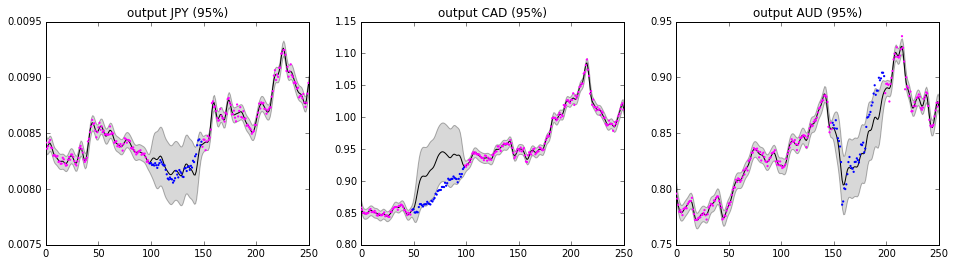

In [7]:
# Prints best lmc model
test_fx = [k for k, v in holdout.items() if v.start != v.stop]
pred_xss = [all_ixs if col in test_fx else [] for col in fx2007.columns]
pred_yss, pred_vss = best.predict(pred_xss)
pred_xss = {col: xs for col, xs in zip(fx2007.columns, pred_xss)}
pred_yss = {col: ys for col, ys in zip(fx2007.columns, pred_yss)}
pred_vss = {col: vs for col, vs in zip(fx2007.columns, pred_vss)}

_, axs = plt.subplots(ncols=3, figsize=(16, 4))
for col, ax in zip(test_fx, axs):
    
    # Prediction everywhere
    pred_xs = pred_xss[col]
    pred_ys = pred_yss[col]
    sd = np.sqrt(pred_vss[col])
    ax.plot(pred_xs, pred_ys, c='black')
    top = pred_ys + 2 * sd
    bot = pred_ys - 2 * sd
    ax.fill_between(pred_xs, bot, top, facecolor='grey', alpha=0.3)    
    
    # Actual holdout
    marker_size = 5
    test_xs = all_ixs[holdout[col]]
    test_ys = np.reciprocal(fx2007.ix[holdout[col], col].values)
    ax.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11)
    
    # Rest of image
    rest_xs = all_ixs[holdin[col]]
    rest_ys = np.reciprocal(fx2007.ix[holdin[col], col].values)
    ax.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10)
    
    ax.set_xlim([0, 250])
    ax.set_title('output {} (95%)'.format(col))


plt.show()